# Requirments

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.func import functional_call, grad, vmap
import torchopt

# Differential equation

The differential equation to solve is:
$$
    \frac{d f}{dt}(t) = R f(t)\left(1 - f(t)\right)
$$
with initial condition $f(0) = 0.5$.

This equation can be used to model population growth.

# Model

The neural entwork we will use to model the function $f$ is a multilayer feedforward neural network that consists of an input layer, several hidden layers and an output layer.  The input of the network consists of a single value, as does the output.

The network is implemented using a PyTorch `Module` and we need to implement the `__init__` function to create the network, and a `forward` function to perform the forward computation.  Each layer is an instance of a `Linear` layer, and all the hidden layers have a $tanh(x)$ transfer function.

In [2]:
class PINN(torch.nn.Module):

    def __init__(self, nr_inputs, nr_layers, nr_neurons, activation=torch.nn.Tanh()):
        super().__init__()
        self.num_inputs = nr_inputs
        self.num_layers = nr_layers
        self.num_neurons = nr_neurons
        layers = []
        layers.append(torch.nn.Linear(self.num_inputs, self.num_neurons))
        for _ in range(self.num_layers):
            layers.append(torch.nn.Linear(self.num_neurons, self.num_neurons))
            layers.append(activation)
        layers.append(torch.nn.Linear(self.num_neurons, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, t):
        return self.network(t.reshape(-1, 1)).squeeze()

In [3]:
nr_inputs, nr_neurons, nr_layers = 1, 5, 5

In [4]:
model = PINN(nr_inputs=nr_inputs, nr_neurons=nr_neurons, nr_layers=nr_layers)

# Loss function

In order to train the network, we need a loss function that describes the difference between the residue of the differential equation and the boundary condition when the output of the neural network is substituted.

The loss function to train the neural network will be the sum of two terms, the first evaluates the differential equation in $M$ time points, the second enforces the initial conditions.
$$
    \begin{array}{lcl}
        L_{\mathrm{DE}} & = & \frac{1}{M} \sum_{j=1}^{M} \left( \frac{df_{\mathrm{NN}}}{dt}(t_j) - R f_{\mathrm{NN}}(t_j) \left( 1 - f_{\mathrm{NN}}(t_j) \right) \right)^2 \\
        L_{\mathrm{BC}} & = & \left( f_{\mathrm{NN}}(0) - 0.5 \right)^2 \\
        L & = & L_{\mathrm{DE}} + L_{\mathrm{BC}}
    \end{array}
$$

To ensure that the various functions the function gets the correct type of input, we need a helper function `tuple_to_dict_parameters` that will convert a tuple of model parameters to an `OrderedDict`.

In [5]:
def tuple_to_dict_parameters(model, params):
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k, v in zip(keys, values)}))

Now we can write a function that computes a function and its derivatives.

In [6]:
def make_forward_functions(model, derivative_order=1):

    def f(t, params):
        if isinstance(params, tuple):
            params_dict = tuple_to_dict_parameters(model, params)
        else:
            params_dict = params
        return functional_call(model, params_dict, (t, ))

    fns = [f]
    dfunc = f
    for _ in range(derivative_order):
        dfunc = grad(dfunc)
        fns.append(vmap(dfunc, in_dims=(0, None)))
    return fns

In [7]:
f, dfdx = make_forward_functions(model, derivative_order=1)

Now we can create a function that creates the actual loss functions.

In [8]:
def make_loss_functions(f, dfdx, R, initial_values):
    t_initial, f_initial = initial_values
    
    def loss_function(params, t):
        f_value = f(t, params)
        function_values = dfdx(t, params) - R*f_value*(1.0 - f_value)
        initial_condition = f(torch.tensor([t_initial]), params) - torch.tensor([f_initial])
        loss = torch.nn.MSELoss()
        return (loss(function_values, torch.zeros_like(function_values)) +
                loss(initial_condition, torch.zeros_like(initial_condition)))
    return loss_function

In [9]:
R, initial_values = 1.0, (0.0, 0.5)

In [10]:
loss_function = make_loss_functions(f, dfdx, R, initial_values)

# Training

We will use an Adam optimizer to minimize the loss function using the learning rate as a parameter.

In [11]:
learning_rate = 1.0e-1

In [12]:
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

Now we get the neural network's current parameters as a tuple.

In [13]:
params = tuple(model.parameters())

In [14]:
batch_size = 50
nr_epochs = 500
input_domain = (-5.0, 5.0)
loss_threshold = 1.0e-5

In [15]:
losses = []
for epoch in range(nr_epochs):
    t = torch.FloatTensor(batch_size).uniform_(*input_domain)
    loss = loss_function(params, t)
    losses.append(float(loss))
    if losses[-1] < loss_threshold:
        break
    params = optimizer.step(loss, params)
    print(f'iteration {epoch + 1} with loss {float(loss)}')

iteration 1 with loss 2.682425022125244
iteration 2 with loss 0.3248419761657715
iteration 3 with loss 0.07937696576118469
iteration 4 with loss 0.062268033623695374
iteration 5 with loss 0.06364761292934418
iteration 6 with loss 0.06295504420995712
iteration 7 with loss 0.062462858855724335
iteration 8 with loss 0.06440162658691406
iteration 9 with loss 0.06790334731340408
iteration 10 with loss 0.07088378071784973
iteration 11 with loss 0.07126767933368683
iteration 12 with loss 0.06905809789896011
iteration 13 with loss 0.0657154843211174
iteration 14 with loss 0.06308221817016602
iteration 15 with loss 0.06241083890199661
iteration 16 with loss 0.06337125599384308
iteration 17 with loss 0.06508059799671173
iteration 18 with loss 0.06629833579063416
iteration 19 with loss 0.06615020334720612
iteration 20 with loss 0.06492339819669724
iteration 21 with loss 0.06342058628797531
iteration 22 with loss 0.06253460794687271
iteration 23 with loss 0.06255137175321579
iteration 24 with loss

Plot the result of a new random sample of $t$ values.

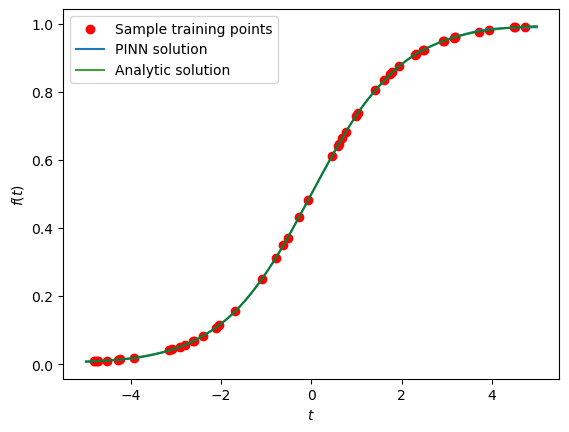

In [16]:
t_initial, f_initial = initial_values
t_eval = torch.linspace(*input_domain, steps=100).reshape(-1, 1)
f_eval = f(t_eval, params)
analytical_sol_fn = lambda t: 1.0/(1.0 + (1.0/f_initial - 1.0)*np.exp(-R*t))
t_eval_np = t_eval.detach().numpy()
t_sample_np = torch.FloatTensor(batch_size).uniform_(*input_domain).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(t_sample_np, analytical_sol_fn(t_sample_np), color='red',
           label='Sample training points')
ax.plot(t_eval_np, f_eval.detach().numpy(), label='PINN solution')
ax.plot(t_eval_np, analytical_sol_fn(t_eval_np), label='Analytic solution',
        color='green', alpha=0.75)
ax.set(xlabel=r'$t$', ylabel=r'$f(t)$')
ax.legend();

The evolution of the loss function as a function of the epoch is plotted below.

[Text(0.5, 0, 'nr. epochs'), Text(0, 0.5, 'Loss')]

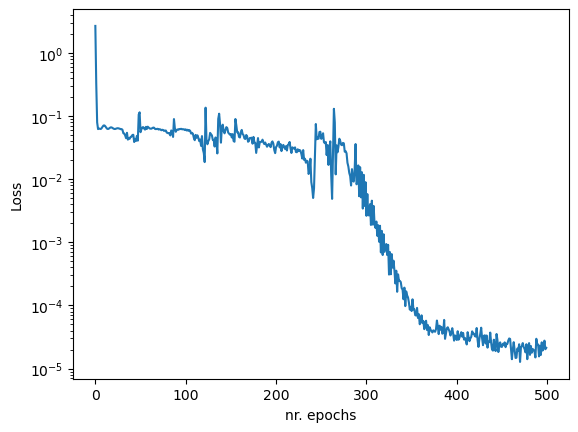

In [17]:
fig, ax = plt.subplots()
ax.semilogy(losses)
ax.set(xlabel='nr. epochs', ylabel='Loss')

The loss doesn't decrease monotonically since for each epoch a new random sample of time values is chosen.